In [1]:
# Install Libraries

%pip install pandas scikit-learn jupyterlab ipywidgets plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load Data & Train Model
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact, HBox, VBox
from IPython.display import display, clear_output
import warnings

# Suppress warnings for a cleaner notebook
warnings.filterwarnings('ignore')

In [3]:
# 1. Load the data created by your R script
try:
    all_data = pd.read_csv("minecraft_dashboard_data.csv")
except FileNotFoundError:
    print("ERROR: 'minecraft_dashboard_data.csv' not found.")
    print("Please run the '01_Data_Prep.ipynb' notebook first!")
else:
    print("Data loaded successfully.")

    # 2. Train the Subscription Model
    print("Training subscription prediction model...")
    features = ['age', 'experience', 'total_played_hours', 'total_sessions']
    target = 'subscribe'

    # Drop rows where target is NA, if any
    model_data = all_data.dropna(subset=[target])

    X = model_data[features]
    y = model_data[target]

    # Set up preprocessing
    categorical_features = ['experience']
    numeric_features = ['age', 'total_played_hours', 'total_sessions']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # Create the full model pipeline
    sub_model = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', LogisticRegression())])

    # Train the model
    sub_model.fit(X, y)

    print("Model trained successfully. Dashboard is ready.")

Data loaded successfully.
Training subscription prediction model...
Model trained successfully. Dashboard is ready.


In [4]:
# Tab 1 - Interactive Overview
print("--- Dashboard Tab 1: Project Overview ---")

@interact
def update_plot(
    experience_filter=widgets.SelectMultiple(
        options=all_data['experience'].unique(),
        value=list(all_data['experience'].unique()),
        description='Experience:',
        layout={'width': 'max-content'}
    ),
    age_slider=widgets.FloatRangeSlider(
        value=[all_data['age'].min(), all_data['age'].max()],
        min=all_data['age'].min(),
        max=all_data['age'].max(),
        step=1,
        description='Age Range:',
        layout={'width': '500px'}
    )
):
    # Filter data based on widget inputs
    filtered_df = all_data[
        (all_data['experience'].isin(experience_filter)) &
        (all_data['age'] >= age_slider[0]) &
        (all_data['age'] <= age_slider[1])
    ]
    
    # Create the plot
    fig = px.scatter(
        filtered_df,
        x='age',
        y='total_played_hours',
        color='experience',
        title='Fig 1: Played Hours vs. Age (Interact with widgets above!)'
    )
    fig.show()

--- Dashboard Tab 1: Project Overview ---


interactive(children=(SelectMultiple(description='Experience:', index=(0, 1, 2, 3, 4), layout=Layout(width='ma…

--- Dashboard Tab 2: Player Personas (Clustering) ---


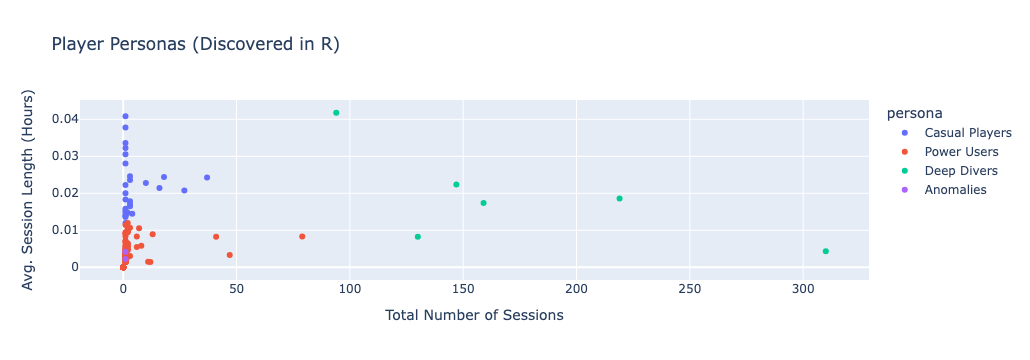

In [5]:
# Tab 2 - Player Personas
print("--- Dashboard Tab 2: Player Personas (Clustering) ---")

fig = px.scatter(
    all_data,
    x='total_sessions',
    y='average_session_length',
    color='persona',
    title='Player Personas (Discovered in R)',
    labels={'total_sessions': 'Total Number of Sessions', 'average_session_length': 'Avg. Session Length (Hours)'},
    hover_data=['age', 'total_played_hours']
)
fig.show()

In [6]:
# Tab 3 - Subscription Predictor
print("--- Dashboard Tab 3: Subscription Predictor Tool ---")

# 1. Create the widgets
age_input = widgets.IntSlider(value=20, min=5, max=100, description='Age:')
exp_input = widgets.Dropdown(options=all_data['experience'].unique(), description='Experience:')
hours_input = widgets.IntSlider(value=10, min=0, max=200, description='Total Hours:')
sessions_input = widgets.IntSlider(value=5, min=0, max=200, description='Total Sessions:')
predict_button = widgets.Button(description='Predict Likelihood', button_style='primary')
output_box = widgets.Output() 

# 2. Define the prediction function
def on_predict_button_clicked(b):
    with output_box:
        output_box.clear_output()
        
        # Create a DataFrame from inputs
        new_data = pd.DataFrame({
            'age': [age_input.value],
            'experience': [exp_input.value],
            'total_played_hours': [hours_input.value],
            'total_sessions': [sessions_input.value]
        })
        
        # Get probability
        prob = sub_model.predict_proba(new_data)[0][1] # Get prob of 'TRUE' (which is 1)
        prob_percent = prob * 100
        
        print(f"Prediction Complete:")
        print(f"This player has a {prob_percent:.1f}% likelihood to subscribe.")

# 3. Link the button to the function
predict_button.on_click(on_predict_button_clicked)

# 4. Display the widgets
print("Enter player details to predict subscription likelihood:")
display(VBox([age_input, exp_input, hours_input, sessions_input, predict_button, output_box]))

--- Dashboard Tab 3: Subscription Predictor Tool ---
Enter player details to predict subscription likelihood:
